In [119]:
from importlib import reload  # Python 3.4+

import sys
sys.path.append("..")
import helper.helper as h
import helper.methods as m
import pickle
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from timeit import default_timer as timer
import itertools

### Generating Data
Parameters:
- $p$, number of variables.
- $s$, number of arcs.
- $|s|$, size of autoregressive coefficients.
- $T$, number of timesteps.

In [129]:
import math

[[ 0.5  0.   0.  ...  0.5  0.   0.5]
 [ 0.   0.5  0.  ...  0.   0.   0. ]
 [ 0.   0.   0.5 ... -0.5  0.   0. ]
 ...
 [ 0.   0.   0.  ...  0.5  0.   0. ]
 [ 0.   0.   0.  ...  0.   0.5  0. ]
 [ 0.   0.   0.  ...  0.   0.5  0.5]]


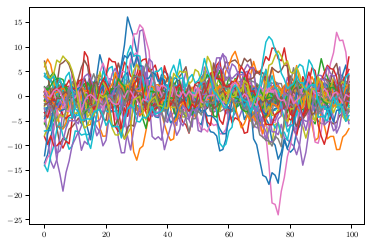

In [364]:
def gen_W(p, s, low, high, acyclic = True, regress = 0, seed = 12345):
    np.random.seed(seed)
    
    W = np.zeros((p, p))
    # randomly generate an acyclic coefficient matrix, fill diagonals
    
    if acyclic:
        # generate s off-diagonal elements uniform between +- low, high
        arcs = np.array([0.0] * (int(p * (p + 1) / 2) - s - p) + [1.0] * s)
        arcs[arcs > 0] = (2 * np.random.randint(0, 2, size=(s)) - 1) * np.random.uniform(low, high, s)
        np.random.shuffle(arcs)
    
        W[np.tril_indices(p, - 1)] = arcs
        
        P = np.random.permutation(np.identity(p))
        W = P.T @ W @ P

    #else:
        # generate acyclicly s off-diagonal elements uniform between +- low high
    
    
    # fill diagonal based on strength
    for i in range(p):
        W[i][i] = 0.5 + 0.2 * regress
        
    return W

def cov_X(W):
    
    p = np.shape(W)[0]
    # covariance matrix
    return (np.linalg.inv(np.identity(p ** 2) - np.kron(W.T, W.T)) @ np.identity(p).reshape(p ** 2)).reshape((p, p))

def expected_cost_var(W_true, W_est):
    
    # covariance matrix
    covariance_matrix = np.identity(p) + np.matmul((W_true - W_est).T, np.matmul(cov_X(W_true), (W_true - W_est)))
    
    # return expected MSE
    return np.trace(covariance_matrix)

def gen_var(W, T, seed = 123245):
    np.random.seed(seed)
    
    # get number of variables
    p = np.shape(W)[0]
    
    # Initialize series
    X = np.array(np.zeros((T, p)))

    # noise 
    noise = np.vstack((np.random.multivariate_normal(np.zeros(p), cov_X(W), 1), np.random.multivariate_normal(np.zeros(p), np.identity(p), T - 1)))
    X[0] = noise[0]
    
    # Generate series
    for t in range(1, T):
        # First the randomness
        X[t] = X[t - 1] @ W + noise[t]
    
    # Return series
    return X

def gen_data(p, s, T, low = 0.5, high = 0.5, regress = 0, seed = 12345):
    # generate matrix
    W = gen_W(p, min(3 * p, int(p * (p - 1) / 2)), low, high, regress = regress, seed = seed)
    
    # generate VAR(1) model in stationary distribution
    X = gen_var(W, T, seed = seed)

    return W, X, 

W, X = gen_data(p = 50, s = 50, T = 100, regress = 0, seed = 1)
print(W)
plt.plot(X);

### Generate the datasets

In [365]:
from tqdm import tqdm
datasets = []

p_range = [5, 10, 15,25, 50]

for p in tqdm(p_range):
    datasets_p = []
    for i in range(10):
        W, X = gen_data(p, 0, 1000, seed = i)
        datasets_p.append((W, X))
        # plt.plot(X)
        # plt.show()
    datasets.append(datasets_p)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.63s/it]


In [366]:
def con_OLS(X, B):
    W = np.zeros((p, p))
    for i in range(p):
        X_F = X[:, B[:, i]]
        W[B[:, i], i] = np.linalg.inv(X_F[:-1].T @ X_F[:-1]) @ X_F[:-1].T @ X[1:, i]
        
    return W

In [367]:
def evaluate(results, X, W_true, W_m, method, epsilon = 0.30, verbose = True):
    # get mse
    _, _, _, _, shd_1, mse, _ = h.score(X, W_m, W_true, printing = False)
    results[method]['mse'].append(mse)

    
    # do thresholding to get shd
    W_m[np.abs(W_m) <= epsilon] = 0

    _, _, _, _, shd, _, _ = h.score(X, W_m, W_true, printing = False)
    results[method]['shd'].append(shd)
    
    # do reestimated to get expected mean squared error
    emse = expected_cost_var(W_true, con_OLS(X, W_m != 0))
    results[method]['emse'].append(emse)
    
    if verbose:
        print(method)
        print(f"SHD: {shd}, Empirial Risk: {round(mse, 3)}, True Risk: {round(emse, 3)}.")
        
    return results

In [368]:
# mean squared, true risk, and shd per method
results = {
    "exh": {"mse": [], "emse": [], "shd": []},
    "rw_1": {"mse": [], "emse": [], "shd": []},
    "rw_2": {"mse": [], "emse": [], "shd": []},
    "mcmc_r": {"mse": [], "emse": [], "shd": []},
    "mcmc_t": {"mse": [], "emse": [], "shd": []},
    "mcmc_s": {"mse": [], "emse": [], "shd": []},
    "mcmc_g": {"mse": [], "emse": [], "shd": []},
    "notears": {"mse": [], "emse": [], "shd": []},
    "daglasso": {"mse": [], "emse": [], "shd": []},
    "dagomp": {"mse": [], "emse": [], "shd": []},
    "dagols": {"mse": [], "emse": [], "shd": []},
}


In [369]:
import time
iters = 1000

old_time = time.time()
# for each dataset
for dataset in datasets:
    for W, X in dataset:
        # for each method:
        T, p = np.shape(X)
        m.T, m.p = T, p
    
    # covariance_X = np.matmul(np.linalg.inv(np.identity(p ** 2) - np.kron(W.T, W.T)), np.identity(p).reshape(p ** 2)).reshape((p, p))
    
    # 1: Exhaustive:
#     if p <= 8:
#         W_exh = m.exh(X[:-1], X[1:])
        
#         # 2.1: Random Walk 1, need regularizing
#         W_rw_1 = m.rw_1(X[:-1], X[1:], np.identity(p), iters)[1]
#         results = evaluate(results, X, W, W_rw_1, "rw_1")
    
    # 2.2: Random Walk 2
#         W_rw_2 = m.rw_2(X[:-1], X[1:], np.identity(p), iters)[1]
#         results = evaluate(results, X, W, W_rw_2, "rw_2")
    
#     # 3.1: MCMC 1
#         W_mcmc_1 = m.mcmc_1(X[:-1], X[1:], iters, np.identity(p))[1]
#         results = evaluate(results, X, W, W_mcmc_1, "mcmc_r")
    
#     # 3.2: MCMC 2
#     W_mcmc_2 = m.mcmc_2(X[:-1], X[1:], iters, np.identity(p))[1]
#     results = evaluate(results, X, W, W_mcmc_2, "mcmc_t")
    
#     # 3.3: MCMC 3
#     W_mcmc_3 = m.mcmc_3(X[:-1], X[1:], iters, np.identity(p))[1]
#     results = evaluate(results, X, W, W_mcmc_3, "mcmc_s")
    
#     # 3.4: MCMC 4
#         W_mcmc_4 = m.mcmc_4(X[:-1], X[1:], iters, np.identity(p))[1]
#         results = evaluate(results, X, W, W_mcmc_4, "mcmc_g")
    
    # 4: NO TEARS, NEED TO REGULARIZE using bootstrap.
        W_notears, _ = m.notears_2(X, lambda1 = 0.0)
        results = evaluate(results, X, W, W_notears, "notears")
    
        # 5: LASSO-DAG, NEED TO REGULARIZE using bootstrap.
        W_lassodag, alpha = m._LASSO_LINGNAM(X, step_size = 0.1)
        print("DAG-LASSO alpha:", alpha)
        results = evaluate(results, X, W, W_lassodag, "daglasso")
    
    # 6: DAG-OMP, NEED TO REGULARIZE using cross-validation.
        W_omp, _ = m._K_OMP(X[:-1], X[1:], F = [], normalize = True)
        results = evaluate(results, X, W, W_omp, "dagomp")
    
#         # 7: DAG-LASSO, NEED TO REGULARIZE using bootstrap.
#         W_olsdag = con_OLS(X, m._OLS_LINGNAM(X)[0] != 0)
#         results = evaluate(results, X, W, W_olsdag, "dagols")
        
print(f"Done! Took {time.time() - old_time} seconds.")

notears
SHD: 0, Empirial Risk: 4.838, True Risk: 5.011.
DAG-LASSO alpha: 2.9000000000000012
daglasso
SHD: 14, Empirial Risk: 15.103, True Risk: 18.553.
dagomp
SHD: 0, Empirial Risk: 4.838, True Risk: 5.011.
notears
SHD: 0, Empirial Risk: 5.016, True Risk: 5.012.
DAG-LASSO alpha: 0.2
daglasso
SHD: 3, Empirial Risk: 5.344, True Risk: 5.971.
dagomp
SHD: 0, Empirial Risk: 5.016, True Risk: 5.012.
notears
SHD: 0, Empirial Risk: 5.034, True Risk: 5.016.
DAG-LASSO alpha: 2.500000000000001
daglasso
SHD: 14, Empirial Risk: 13.458, True Risk: 14.054.
dagomp
SHD: 0, Empirial Risk: 5.034, True Risk: 5.016.
notears
SHD: 0, Empirial Risk: 4.93, True Risk: 5.027.
DAG-LASSO alpha: 0.30000000000000004
daglasso
SHD: 3, Empirial Risk: 5.652, True Risk: 5.932.
dagomp
SHD: 0, Empirial Risk: 4.93, True Risk: 5.027.
notears
SHD: 0, Empirial Risk: 4.779, True Risk: 5.013.
DAG-LASSO alpha: 2.500000000000001
daglasso
SHD: 14, Empirial Risk: 13.616, True Risk: 18.151.
dagomp
SHD: 0, Empirial Risk: 4.779, True Ri

..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 0, Empirial Risk: 9.941, True Risk: 10.044.
DAG-LASSO alpha: 3.1000000000000014
daglasso
SHD: 36, Empirial Risk: 33.924, True Risk: 41.448.
dagomp
SHD: 0, Empirial Risk: 9.94, True Risk: 10.044.
notears
SHD: 0, Empirial Risk: 9.85, True Risk: 10.058.
DAG-LASSO alpha: 5.1999999999999975
daglasso
SHD: 38, Empirial Risk: 37.327, True Risk: 47.123.
dagomp
SHD: 0, Empirial Risk: 9.85, True Risk: 10.058.
notears
SHD: 0, Empirial Risk: 9.862, True Risk: 10.024.
DAG-LASSO alpha: 4.5
daglasso
SHD: 37, Empirial Risk: 44.179, True Risk: 45.262.
dagomp
SHD: 0, Empirial Risk: 9.859, True Risk: 10.024.
notears
SHD: 0, Empirial Risk: 9.951, True Risk: 10.049.
DAG-LASSO alpha: 4.4
daglasso
SHD: 37, Empirial Risk: 40.128, True Risk: 40.475.
dagomp
SHD: 0, Empirial Risk: 9.951, True Risk: 10.049.


..\notears\notears\notears\linear.py:73: RuntimeWarning: overflow encountered in double_scalars
  obj = loss + 0.5 * rho * h * h + alpha * h + lambda1 * w.sum()
..\notears\notears\notears\linear.py:74: RuntimeWarning: overflow encountered in multiply
  G_smooth = G_loss + (rho * h + alpha) * G_h
..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 0, Empirial Risk: 9.801, True Risk: 10.036.
DAG-LASSO alpha: 6.499999999999993
daglasso
SHD: 37, Empirial Risk: 47.596, True Risk: 62.551.
dagomp
SHD: 0, Empirial Risk: 9.798, True Risk: 10.036.


..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 0, Empirial Risk: 9.799, True Risk: 10.053.
DAG-LASSO alpha: 5.699999999999996
daglasso
SHD: 34, Empirial Risk: 38.612, True Risk: 50.878.
dagomp
SHD: 3, Empirial Risk: 11.255, True Risk: 12.754.
notears
SHD: 0, Empirial Risk: 10.007, True Risk: 10.054.
DAG-LASSO alpha: 1.8000000000000005
daglasso
SHD: 32, Empirial Risk: 25.099, True Risk: 27.916.
dagomp
SHD: 0, Empirial Risk: 10.005, True Risk: 10.054.


..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 0, Empirial Risk: 9.895, True Risk: 10.045.
DAG-LASSO alpha: 1.5000000000000002
daglasso
SHD: 35, Empirial Risk: 26.706, True Risk: 29.776.
dagomp
SHD: 0, Empirial Risk: 9.895, True Risk: 10.045.
notears
SHD: 0, Empirial Risk: 14.503, True Risk: 15.091.
DAG-LASSO alpha: 3.5000000000000018
daglasso
SHD: 54, Empirial Risk: 48.494, True Risk: 49.489.
dagomp
SHD: 0, Empirial Risk: 14.498, True Risk: 15.091.


..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 0, Empirial Risk: 14.855, True Risk: 15.077.
DAG-LASSO alpha: 5.999999999999995
daglasso
SHD: 55, Empirial Risk: 64.367, True Risk: 83.263.
dagomp
SHD: 0, Empirial Risk: 14.848, True Risk: 15.077.


..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 0, Empirial Risk: 14.951, True Risk: 15.047.
DAG-LASSO alpha: 6.099999999999994
daglasso
SHD: 52, Empirial Risk: 55.177, True Risk: 64.998.
dagomp
SHD: 6, Empirial Risk: 18.879, True Risk: 20.137.


..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 0, Empirial Risk: 14.699, True Risk: 15.079.
DAG-LASSO alpha: 4.200000000000001
daglasso
SHD: 54, Empirial Risk: 56.846, True Risk: 58.909.
dagomp
SHD: 0, Empirial Risk: 14.704, True Risk: 15.079.


..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 0, Empirial Risk: 14.842, True Risk: 15.063.
DAG-LASSO alpha: 5.599999999999996
daglasso
SHD: 56, Empirial Risk: 68.089, True Risk: 71.894.
dagomp
SHD: 0, Empirial Risk: 14.836, True Risk: 15.063.


..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 0, Empirial Risk: 14.909, True Risk: 15.06.
DAG-LASSO alpha: 8.999999999999984
daglasso
SHD: 58, Empirial Risk: 82.411, True Risk: 84.801.
dagomp
SHD: 0, Empirial Risk: 14.897, True Risk: 15.06.


..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 0, Empirial Risk: 14.681, True Risk: 15.05.
DAG-LASSO alpha: 4.5
daglasso
SHD: 55, Empirial Risk: 58.506, True Risk: 74.326.
dagomp
SHD: 0, Empirial Risk: 14.676, True Risk: 15.05.
notears
SHD: 0, Empirial Risk: 14.493, True Risk: 15.063.
DAG-LASSO alpha: 4.200000000000001
daglasso
SHD: 57, Empirial Risk: 52.9, True Risk: 59.861.
dagomp
SHD: 0, Empirial Risk: 14.491, True Risk: 15.063.
notears
SHD: 0, Empirial Risk: 15.065, True Risk: 15.088.
DAG-LASSO alpha: 5.099999999999998
daglasso
SHD: 52, Empirial Risk: 67.01, True Risk: 65.647.
dagomp
SHD: 0, Empirial Risk: 15.063, True Risk: 15.088.


..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 0, Empirial Risk: 14.876, True Risk: 15.051.
DAG-LASSO alpha: 5.799999999999995
daglasso
SHD: 57, Empirial Risk: 71.879, True Risk: 81.249.
dagomp
SHD: 3, Empirial Risk: 17.05, True Risk: 17.815.


..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 0, Empirial Risk: 24.215, True Risk: 25.077.
DAG-LASSO alpha: 10.799999999999978
daglasso
SHD: 99, Empirial Risk: 139.805, True Risk: 228.404.
dagomp
SHD: 0, Empirial Risk: 24.196, True Risk: 25.077.


..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 0, Empirial Risk: 24.689, True Risk: 25.102.
DAG-LASSO alpha: 3.1000000000000014
daglasso
SHD: 87, Empirial Risk: 79.451, True Risk: 85.997.
dagomp
SHD: 0, Empirial Risk: 24.671, True Risk: 25.102.


..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 0, Empirial Risk: 24.815, True Risk: 25.086.
DAG-LASSO alpha: 4.699999999999999
daglasso
SHD: 91, Empirial Risk: 110.592, True Risk: 125.074.
dagomp
SHD: 0, Empirial Risk: 24.804, True Risk: 25.086.
notears
SHD: 0, Empirial Risk: 24.496, True Risk: 25.113.
DAG-LASSO alpha: 4.100000000000001
daglasso
SHD: 91, Empirial Risk: 99.0, True Risk: 117.735.
dagomp
SHD: 2, Empirial Risk: 25.299, True Risk: 26.292.


..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 0, Empirial Risk: 24.45, True Risk: 25.117.
DAG-LASSO alpha: 4.100000000000001
daglasso
SHD: 90, Empirial Risk: 96.738, True Risk: 102.451.
dagomp
SHD: 0, Empirial Risk: 24.439, True Risk: 25.117.
notears
SHD: 0, Empirial Risk: 24.816, True Risk: 25.095.
DAG-LASSO alpha: 10.599999999999978
daglasso
SHD: 94, Empirial Risk: 138.428, True Risk: 156.528.
dagomp
SHD: 0, Empirial Risk: 24.799, True Risk: 25.095.
notears
SHD: 0, Empirial Risk: 24.305, True Risk: 25.119.
DAG-LASSO alpha: 4.000000000000002
daglasso
SHD: 89, Empirial Risk: 96.658, True Risk: 106.742.
dagomp
SHD: 2, Empirial Risk: 25.257, True Risk: 26.283.
notears
SHD: 0, Empirial Risk: 24.278, True Risk: 25.108.
DAG-LASSO alpha: 12.199999999999973
daglasso
SHD: 95, Empirial Risk: 157.906, True Risk: 209.388.
dagomp
SHD: 0, Empirial Risk: 24.246, True Risk: 25.108.


..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 0, Empirial Risk: 24.857, True Risk: 25.11.
DAG-LASSO alpha: 8.999999999999984
daglasso
SHD: 96, Empirial Risk: 126.415, True Risk: 143.819.
dagomp
SHD: 0, Empirial Risk: 24.842, True Risk: 25.11.
notears
SHD: 0, Empirial Risk: 24.547, True Risk: 25.085.
DAG-LASSO alpha: 3.0000000000000013
daglasso
SHD: 87, Empirial Risk: 80.781, True Risk: 85.826.
dagomp
SHD: 0, Empirial Risk: 24.554, True Risk: 25.085.


..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 0, Empirial Risk: 48.353, True Risk: 50.212.
DAG-LASSO alpha: 9.199999999999983
daglasso
SHD: 187, Empirial Risk: 268.134, True Risk: 332.639.
dagomp
SHD: 0, Empirial Risk: 48.22, True Risk: 50.212.
notears
SHD: 0, Empirial Risk: 48.756, True Risk: 50.199.
DAG-LASSO alpha: 6.799999999999992
daglasso
SHD: 183, Empirial Risk: 245.126, True Risk: 252.526.
dagomp
SHD: 0, Empirial Risk: 48.71, True Risk: 50.199.


..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 0, Empirial Risk: 48.872, True Risk: 50.175.
DAG-LASSO alpha: 8.199999999999987
daglasso
SHD: 185, Empirial Risk: 259.062, True Risk: 263.068.
dagomp
SHD: 0, Empirial Risk: 48.736, True Risk: 50.175.


..\notears\notears\notears\linear.py:73: RuntimeWarning: overflow encountered in double_scalars
  obj = loss + 0.5 * rho * h * h + alpha * h + lambda1 * w.sum()
..\notears\notears\notears\linear.py:74: RuntimeWarning: overflow encountered in multiply
  G_smooth = G_loss + (rho * h + alpha) * G_h


notears
SHD: 0, Empirial Risk: 48.534, True Risk: 50.197.
DAG-LASSO alpha: 6.5999999999999925
daglasso
SHD: 184, Empirial Risk: 255.815, True Risk: 275.557.
dagomp
SHD: 0, Empirial Risk: 48.426, True Risk: 50.197.
notears
SHD: 0, Empirial Risk: 48.401, True Risk: 50.196.
DAG-LASSO alpha: 10.499999999999979
daglasso
SHD: 188, Empirial Risk: 295.472, True Risk: 293.567.
dagomp
SHD: 0, Empirial Risk: 48.285, True Risk: 50.196.
notears
SHD: 0, Empirial Risk: 48.83, True Risk: 50.198.
DAG-LASSO alpha: 8.099999999999987
daglasso
SHD: 186, Empirial Risk: 262.934, True Risk: 291.917.
dagomp
SHD: 0, Empirial Risk: 48.784, True Risk: 50.198.


..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 0, Empirial Risk: 48.27, True Risk: 50.186.
DAG-LASSO alpha: 9.99999999999998
daglasso
SHD: 190, Empirial Risk: 294.521, True Risk: 298.324.
dagomp
SHD: 0, Empirial Risk: 48.137, True Risk: 50.186.


..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 0, Empirial Risk: 48.174, True Risk: 50.184.
DAG-LASSO alpha: 7.499999999999989
daglasso
SHD: 183, Empirial Risk: 229.004, True Risk: 231.435.
dagomp
SHD: 3, Empirial Risk: 49.302, True Risk: 54.495.


..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 0, Empirial Risk: 48.945, True Risk: 50.204.
DAG-LASSO alpha: 13.199999999999969
daglasso
SHD: 185, Empirial Risk: 404.67, True Risk: 469.882.
dagomp
SHD: 0, Empirial Risk: 48.74, True Risk: 50.204.


..\notears\notears\notears\linear.py:61: RuntimeWarning: invalid value encountered in multiply
  G_h = E.T * W2 * 2


notears
SHD: 0, Empirial Risk: 48.572, True Risk: 50.169.
DAG-LASSO alpha: 4.899999999999999
daglasso
SHD: 175, Empirial Risk: 185.92, True Risk: 198.484.
dagomp
SHD: 0, Empirial Risk: 48.52, True Risk: 50.169.
Done! Took 4565.447313308716 seconds.


### Plotting

In [237]:
method = "daglasso"
print(results[method])
results[method]["mse"] = []
results[method]["shd"] = []
results[method]["emse"] = []

{'mse': [], 'emse': [], 'shd': []}


In [199]:
from scipy.stats import sem

In [374]:
for method in results:
    print(method)
    for metric in results[method]:
        print(metric)
        print([np.round(np.mean(results[method][metric][10*i:10*i + 10]), 2) for i in range(5)])

exh
mse
[nan, nan, nan, nan, nan]
emse
[nan, nan, nan, nan, nan]
shd
[nan, nan, nan, nan, nan]
rw_1
mse
[nan, nan, nan, nan, nan]
emse
[nan, nan, nan, nan, nan]
shd
[nan, nan, nan, nan, nan]
rw_2
mse
[nan, nan, nan, nan, nan]
emse
[nan, nan, nan, nan, nan]
shd
[nan, nan, nan, nan, nan]
mcmc_r
mse
[nan, nan, nan, nan, nan]
emse
[nan, nan, nan, nan, nan]
shd
[nan, nan, nan, nan, nan]
mcmc_t
mse
[nan, nan, nan, nan, nan]
emse
[nan, nan, nan, nan, nan]
shd
[nan, nan, nan, nan, nan]
mcmc_s
mse
[nan, nan, nan, nan, nan]
emse
[nan, nan, nan, nan, nan]
shd
[nan, nan, nan, nan, nan]
mcmc_g
mse
[nan, nan, nan, nan, nan]
emse
[nan, nan, nan, nan, nan]
shd
[nan, nan, nan, nan, nan]
notears
mse
[4.95, 9.87, 14.79, 24.55, 48.57]
emse
[5.02, 10.04, 15.07, 25.1, 50.19]
shd
[0.0, 0.0, 0.0, 0.0, 0.0]
daglasso
mse
[9.19, 38.92, 62.57, 112.58, 270.07]
emse
[10.72, 46.02, 69.44, 136.2, 290.74]
shd
[9.1, 36.1, 55.0, 91.9, 184.6]
dagomp
mse
[4.95, 10.18, 15.39, 24.71, 48.59]
emse
[5.02, 10.52, 15.85, 25.34, 

In [258]:
import matplotlib

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'font.size': 8
})

matplotlib.rcParams['axes.unicode_minus'] = False


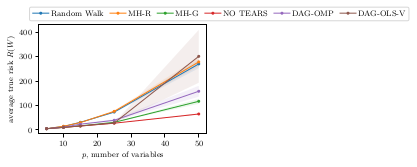

In [360]:
plt.figure(figsize = (3.0, 2.0))
plt.xlabel("$p$, number of variables")
# plt.ylabel("average empirical risk " + r"$R_{\mathrm{emp}}(W)$")
plt.ylabel("average true risk " + r"$R(W)$")
# plt.ylabel("average SHD$")
def plot_results(method, metric, results, method_name, linestyle = '-'):
    # plot mean and standard error of DAG-OMP as a function of p.
    plt.plot(p_range, [np.mean(results[method][metric][10*i:10*i + 10]) for i in range(5)], marker = 'o', markersize = 2, linewidth = 1, label = method_name, linestyle = linestyle)
    plt.fill_between(p_range, [np.mean(results[method][metric][10*i:10*i + 10]) - sem(results[method][metric][10*i:10*i + 10])for i in range(5)], [np.mean(results[method][metric][10*i:10*i + 10]) + sem(results[method][metric][10*i:10*i + 10])for i in range(5)], alpha = 0.1)

metric = "emse"

plot_results("rw_2", metric, results, "Random Walk")
plot_results("mcmc_r", metric, results, "MH-R")
plot_results("mcmc_g", metric, results, "MH-G")

plot_results("notears", metric, results, "NO TEARS")
plot_results("dagomp", metric, results, "DAG-OMP")
plot_results("dagols", metric, results, "DAG-OLS-V")

# plot_results("daglasso", metric, results, "DAG-LASSO")
plt.legend(ncol = 6, loc = 'upper left', bbox_to_anchor=(-0.08, 1.2), columnspacing = 0.75, handletextpad = 0.25)
plt.savefig("empriskresultsacyclicT100denseemse.pgf", bbox_inches = 'tight')

In [370]:
a_file = open(f"{datetime.now().strftime('%d_%m_%Y_%H_%M_%S')}datamatricesT100dense.pkl", "wb")
pickle.dump(datasets, a_file)
a_file.close()

In [375]:
a_file = open(f"{datetime.now().strftime('%d_%m_%Y_%H_%M_%S')}sparseT1000notearslasso.pkl", "wb")
pickle.dump(results, a_file)
a_file.close()

In [135]:
print(results)

{'exh': {'mse': [], 'emse': [], 'shd': []}, 'rw_1': {'mse': [15.51930938321329, 14.924349291129303, 13.660942854655335], 'emse': [17.516740093308872, 15.401844761611144, 14.704537659885943], 'shd': [8, 5, 7]}, 'rw_2': {'mse': [13.999709388260959, 12.228860513658205, 11.009037499064128], 'emse': [16.00566941217162, 12.829642876442566, 11.46746177572549], 'shd': [8, 5, 3]}, 'mcmc_r': {'mse': [12.024503788670984, 13.31533144689828, 11.482735353102102], 'emse': [13.335378788807015, 13.635525214870079, 11.938330731617661], 'shd': [3, 6, 4]}, 'mcmc_t': {'mse': [13.613771055732878, 13.922145699454504, 13.337233489153268], 'emse': [18.70094473651455, 14.918398467202367, 14.102116452002623], 'shd': [8, 9, 6]}, 'mcmc_s': {'mse': [15.12822142217938, 12.884178708481915, 13.69909986030214], 'emse': [17.585350786235104, 14.172125584287423, 13.930770954147391], 'shd': [9, 5, 4]}, 'mcmc_g': {'mse': [15.401595274960952, 11.349025040383523, 10.744590216335688], 'emse': [16.325961093178222, 12.0083041498

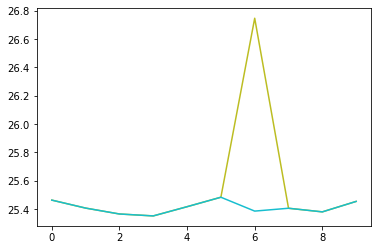

In [160]:
for method in results:
    for metric in results[method]:
        if metric == "emse" and method != "daglasso":
            plt.plot(results[method][metric])

In [177]:
import statsmodels.api as sm
import scipy.linalg as slin

def _h(W):
    """Evaluate value and gradient of acyclicity constraint."""
    W2 = W.copy()

    np.fill_diagonal(W2, np.zeros(np.shape(W)[0]))

    E = slin.expm(W2)  # (Zheng et al. 2018)
    h = np.trace(E) - p

    return h
    
def get_all_violating_edges(W, epsilon = 1e-16):
   
    h_val = _h(W)
    
    violators = set()
    
    for i in range(p):
        for j in range(p):
            if W[i][j] != 0:
                # remove Wij
                tmp = W[i][j]
                W[i][j] = 0
            
                # check h
                h_diff = h_val - _h(W)
            
                # check change
                if np.abs(h_diff) > epsilon:
                    violators.add((i, j))
            
                # add Wij back
                W[i][j] = tmp

    return violators

def B_V_LINGNAM_OLS(X, tol = 0.0):
    """OLS solution W, data X"""
    
    def OLS(X):
        # get regressor and variables
        y = X[1:]
        x = X[:-1]

        # initialize W_hat
        W_hat = np.array([])

        # get parameters
        for i in range(p):
            est = sm.OLS(y[:, i], x).fit()
            W_hat = np.append(W_hat, est.params)

        # return W
        return W_hat.reshape((p, p)).T
    
    # get full OLS solution of W
    W = OLS(X)
    
    # get order of importance
    order_of_importance = []
    
    # scores
    scores = []
    
    # while we still do not have a DAG
    while not h.is_dag(W):       
        print(np.sum(W != 0))
        # get all violating edges
        violators = get_all_violating_edges(W)
        
        # find edge with smallest coefficient
        smallest_coef = np.min([np.abs(W[row][col]) for row, col in violators])
        row, col = np.where(np.abs(W) == smallest_coef)
        row, col = row[0], col[0]
    
        # set this edge to zero
        W[row][col] = 0
        
        # update column
        idx = np.nonzero(W[:, col])[0]
        W[idx, col] = (np.linalg.inv(X[:-1, idx].T @ X[:-1, idx]) @ X[:-1, idx].T @ X[1:, col])
        
        # add edge and score to list
        # order_of_importance.append([row, col])
        # scores.append(h.MSE(W, X))
    
    # we have a dag, return this one for now
    W_return = W.copy()
    
    # Now that we have a DAG, we will greedily remove the least important edge
#     while len(np.nonzero(W)[0]) > 0:   
        
#         # set zero values to impossible value
#         W[W == 0] = 1e10
        
#         # get smallest nonzero coefficient in absolute value
#         row, col = np.argmin(np.abs(W)) // p, np.argmin(np.abs(W)) % p
        
#         # set this to zero
#         W[row][col] = 0
        
#         # revert the zero values back to zero
#         W[W == 1e10] = 0

#         edge = [row, col]
        
#         # update column
#         idx = np.nonzero(W[:, col])[0]
#         W[idx, col] = (np.linalg.inv(X[:-1, idx].T @ X[:-1, idx]) @ X[:-1, idx].T @ X[1:, col])
        
#         score = h.MSE(W, X)
        
#         if score < tol: 
#             break
            
#         order_of_importance.append(edge)
#         scores.append(h.MSE(W, X))
        
    # return the DAG W
    return W_return # , order_of_importance, scores

W_B_V_LINGNAM_OLS = B_V_LINGNAM_OLS(X)
# print(f"OLS solution after iteratively removing the least important violators until we have a DAG:\n{np.round(W_B_V_LINGNAM_OLS, 2)}.")
# print(f"Importance of the removed edges, from least to most important:\n{edge_order}.")
print(W_B_V_LINGNAM_OLS)
plt.figure(figsize = (12, 4))
plt.plot(np.flip(scores))

625
624
623
622
621
620
619
618
617
616
615
614
613
612
611
610
609
608
607
606
605
604
603
602
601
600
599
598
597
596
595
594
593
592
591
590
589
588
587
586
585
584
583
582
581
580
579
578
577
576
575
574
573
572
571
570
569
568
567
566
565
564
563
562
561
560
559
558
557
556
555
554
553
552
551
550
549
548
547
546
545
544
543
542
541
540
539
538
537
536
535
534
533
532
531
530
529
528
527
526
525
524
523
522
521
520
519
518
517
516
515
514
513
512
511
510
509
508
507
506
505
504
503
502
501
500
499
498
497
496
495
494
493
492
491
490
489
488
487
486
485
484
483
482
481
480
479
478
477
476
475
474
473
472
471
470
469
468
467
466
465
464
463
462
461
460
459
458
457
456
455
454
453
452
451
450
449
448
447
446
445
444
443
442
441
440
439
438
437
436
435
434
433
432
431
430
429
428
427
426
425
424
423
422
421
420
419
418
417
416
415
414
413
412
411
410
409
408
407
406
405
404
403
402
401
400
399
398
397
396
395
394
393
392
391
390
389
388
387
386
385
384
383
382
381
380
379
378
377
376


NameError: name 'scores' is not defined

<Figure size 864x288 with 0 Axes>

In [178]:
W_m = W_B_V_LINGNAM_OLS.copy()

In [182]:
_, _, _, _, shd_1, mse, _ = h.score(X, W_m, W, printing = False)
# results[method]['mse'].append(mse)


# do thresholding to get shd
W_m[np.abs(W_m) <= 0.30] = 0

_, _, _, _, shd, _, _ = h.score(X, W_m, W, printing = False)
# results[method]['shd'].append(shd)

# do reestimated to get expected mean squared error
emse = expected_cost_var(W, con_OLS(X, W_m != 0))
# results[method]['emse'].append(emse)

if True:
    # print(method)
    print(f"SHD: {shd}, Empirial Risk: {round(mse, 3)}, True Risk: {round(emse, 3)}.")


SHD: 0, Empirial Risk: 24.691, True Risk: 25.408.
